In [1]:
import polars as pl
import pandas as pd
import time
import numpy as np
import requests
import os
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer
from tqdm import tqdm

In [2]:
df_test = pl.read_csv('data_pop_density/dataframe_densite_amenities.csv')
df_test.tail(5)

lat,lon,densite,amenities,transports,shops,schools,parks,restaurants,healthcare,entertainment,cultural_places
f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64
41.345417,9.244583,8.738704,0,0,0,0,0,0,0,0,0
41.345417,9.252917,16.828238,0,0,0,0,0,0,0,0,0
41.345417,9.26125,14.136576,0,0,0,0,0,0,0,0,0
41.337083,9.252917,13.983237,0,0,0,0,0,0,0,0,0
41.337083,9.26125,12.697619,0,0,0,0,0,0,0,0,0


In [3]:
path_popd ='data_pop_density/fra_pd_2020_1km_ASCII_XYZ.csv'
df_popd = pl.read_csv(path_popd).rename({'X': 'lon','Y':'lat','Z':'densite'})
df_popd.tail(5)

lon,lat,densite
f64,f64,f64
9.244583,41.345417,8.738704
9.252917,41.345417,16.828238
9.26125,41.345417,14.136576
9.252917,41.337083,13.983237
9.26125,41.337083,12.697619


In [4]:
df1 = df_popd.with_columns((pl.col("lon").cast(str) + "," + pl.col("lat").cast(str) + "," + pl.col("densite").cast(str)).alias("key"))
df2 = df_test.with_columns((pl.col("lon").cast(str) + "," + pl.col("lat").cast(str) + "," + pl.col("densite").cast(str)).alias("key"))
result = df1.filter(~pl.col("key").is_in(df2["key"]))[['lon','lat','densite']]
result.head()

lon,lat,densite
f64,f64,f64
0.68625,48.570417,18.352945
0.694583,48.570417,18.051264
0.702917,48.570417,18.05291
0.71125,48.570417,10.625126
0.719583,48.570417,12.273602


# Récupérations des données

## Etape de scrapping (Facultative)

In [5]:
!python script_scrapping_dvf.py

/home/phdel/.pyenv/versions/3.10.6/lib/python3.10/pty.py:89: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

If you really know what your doing, you can silence this warning with the warning module
or by setting POLARS_ALLOW_FORKING_THREAD=1.

  pid, fd = os.forkpty()


Fetching data for year: 2019
File already exists: 01.csv.gz
File already exists: 02.csv.gz
File already exists: 03.csv.gz
File already exists: 04.csv.gz
File already exists: 05.csv.gz
File already exists: 06.csv.gz
File already exists: 07.csv.gz
File already exists: 08.csv.gz
File already exists: 09.csv.gz
File already exists: 10.csv.gz
File already exists: 11.csv.gz
File already exists: 12.csv.gz
File already exists: 13.csv.gz
File already exists: 14.csv.gz
File already exists: 15.csv.gz
File already exists: 16.csv.gz
File already exists: 17.csv.gz
File already exists: 18.csv.gz
File already exists: 19.csv.gz
File already exists: 21.csv.gz
File already exists: 22.csv.gz
File already exists: 23.csv.gz
File already exists: 24.csv.gz
File already exists: 25.csv.gz
File already exists: 26.csv.gz
File already exists: 27.csv.gz
File already exists: 28.csv.gz
File already exists: 29.csv.gz
File already exists: 2A.csv.gz
File already exists: 2B.csv.gz
File already exists: 30.csv.gz
File alrea

## Chargement dans un DataFrame

### Fonctions

In [6]:
def change_column_types(df):
    """
    Change les types de plusieurs colonnes dans un DataFrame Polars.

    Parameters:
        df (pl.DataFrame): Le DataFrame Polars.
        columns_dtypes (dict): Un dictionnaire où les clés sont les noms de colonnes
                               et les valeurs sont les nouveaux types (ex: pl.Int64, pl.Float64).

    Returns:
        pl.DataFrame: Un nouveau DataFrame avec les colonnes modifiées.
    """
    dict_type ={'id_mutation': pl.Utf8, 'date_mutation': pl.Date, 'numero_disposition': pl.Utf8, 'nature_mutation': pl.Utf8, 'valeur_fonciere': pl.Float64, 'adresse_numero' : pl.Utf8, 'adresse_suffixe': pl.Utf8, 'adresse_nom_voie': pl.Utf8, 'adresse_code_voie' : pl.Utf8, 'code_postal':pl.Utf8, 'code_commune':pl.Utf8, 'nom_commune':pl.Utf8, 'code_departement':pl.Utf8, 'ancien_code_commune':pl.Utf8, 'ancien_nom_commune':pl.Utf8, 'id_parcelle':pl.Utf8, 'ancien_id_parcelle':pl.Utf8, 'numero_volume':pl.Utf8, 'lot1_numero':pl.Utf8, 'lot1_surface_carrez':pl.Float64, 'lot2_numero':pl.Utf8, 'lot2_surface_carrez':pl.Float64, 'lot3_numero':pl.Utf8, 'lot3_surface_carrez':pl.Float64, 'lot4_numero':pl.Utf8, 'lot4_surface_carrez':pl.Float64, 'lot5_numero':pl.Utf8, 'lot5_surface_carrez':pl.Float64, 'nombre_lots':pl.Float64, 'code_type_local': pl.Utf8, 'type_local': pl.Utf8, 'surface_reelle_bati': pl.Float64, 'nombre_pieces_principales': pl.Float64, 'code_nature_culture':pl.Utf8, 'nature_culture':pl.Utf8, 'code_nature_culture_speciale':pl.Utf8, 'nature_culture_speciale':pl.Utf8, 'surface_terrain':pl.Float64, 'longitude':pl.Float64, 'latitude':pl.Float64}
    for column_name, column_type in dict_type.items():
        df = df.with_columns(pl.col(column_name).cast(column_type))
    return df

def data_loader(path, departements = [], annees = []):

    df = pl.DataFrame()
    if not annees:
        annees_list = os.listdir(path)
    else:
        annees_list =[str(annee) for annee in annees]
    for annee in annees_list:
        cur_year = os.path.join(path,annee)
        if not departements:
            departements_list = os.listdir(cur_year)
        else:
            departements_list = [f"{departement}.csv.gz" if departement>9 else f"0{departement}.csv.gz" for departement in departements]
        for departement in departements_list:
            file = os.path.join(cur_year,departement)
            temp_df = pl.read_csv(file,ignore_errors=True)
            temp_df = change_column_types(temp_df)
            df = pl.concat([df, temp_df])

    return df


## Chargement des données:

In [7]:
path = 'data_dvf'
df = data_loader(path,departements=[75,92,93,94])

In [8]:
df = df.filter(
    pl.col("valeur_fonciere").is_not_null() &
    pl.col("longitude").is_not_null() &
    pl.col("latitude").is_not_null() &
    (pl.col("surface_reelle_bati").is_not_nan() | pl.col("surface_terrain").is_not_nan())
)
df.head()

id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
str,date,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,f64,str,f64,str,f64,str,f64,f64,str,str,f64,f64,str,str,str,str,f64,f64,f64
"""2023-1317095""",2023-01-03,"""1""","""Vente""",1.825e6,"""89""",null,"""RUE SAINT-DENIS""","""8525""","""75001""","""75101""","""Paris 1er Arrondissement""","""75""",null,null,"""75101000AP0050""",null,null,"""1""",95.21,"""26""",null,"""27""",null,"""28""",null,"""29""",null,7.0,"""4""","""Local industriel. commercial o…",165.0,0.0,null,null,null,null,null,2.349112,48.862083
"""2023-1317096""",2023-01-05,"""1""","""Vente""",567000.0,"""51""",null,"""RUE DE L ECHIQUIER""","""3084""","""75010""","""75110""","""Paris 10e Arrondissement""","""75""",null,null,"""75110000AV0075""",null,null,"""7""",null,"""8""",null,null,null,null,null,null,null,2.0,"""4""","""Local industriel. commercial o…",52.0,0.0,null,null,null,null,null,2.348283,48.871818
"""2023-1317097""",2023-01-04,"""1""","""Vente""",140000.0,"""178""",null,"""RUE DE COURCELLES""","""2387""","""75017""","""75117""","""Paris 17e Arrondissement""","""75""",null,null,"""75117000BG0053""",null,null,"""57""",18.75,"""58""",null,null,null,null,null,null,null,2.0,"""2""","""Appartement""",18.0,1.0,null,null,null,null,null,2.298612,48.884255
"""2023-1317098""",2023-01-05,"""1""","""Vente""",400000.0,"""12""",null,"""RUE TURGOT""","""9508""","""75009""","""75109""","""Paris 9e Arrondissement""","""75""",null,null,"""75109000BD0036""",null,null,"""831""",43.8,null,null,null,null,null,null,null,null,1.0,"""2""","""Appartement""",43.0,1.0,null,null,null,null,null,2.345859,48.880564
"""2023-1317100""",2023-01-03,"""1""","""Vente""",295000.0,"""18""",null,"""RUE EMILE LEVEL""","""3246""","""75017""","""75117""","""Paris 17e Arrondissement""","""75""",null,null,"""75117000DG0040""",null,null,"""14""",null,"""15""",null,null,null,null,null,null,null,2.0,"""2""","""Appartement""",28.0,2.0,null,null,null,null,null,2.318419,48.893075


## BASELINE : Prétraitement des données et premier modèle

In [9]:
data = df[['date_mutation','type_local','surface_reelle_bati','nombre_pieces_principales','nature_culture','surface_terrain','longitude','latitude','valeur_fonciere']]

# # Calculer la composante saisonnière
data = data.with_columns([
    pl.col("date_mutation").dt.month().map_batches(lambda x: np.sin(2 * np.pi * x / 12), return_dtype=pl.Float64).alias("sin_month"),
    pl.col("date_mutation").dt.month().map_batches(lambda x: np.cos(2 * np.pi * x / 12), return_dtype=pl.Float64).alias("cos_month"),
    pl.col("date_mutation").dt.year().alias('year')
])

In [10]:
data.head(2)

date_mutation,type_local,surface_reelle_bati,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,valeur_fonciere,sin_month,cos_month,year
date,str,f64,f64,str,f64,f64,f64,f64,f64,f64,i32
2023-01-03,"""Local industriel. commercial o…",165.0,0.0,null,null,2.349112,48.862083,1.825e6,0.5,0.866025,2023
2023-01-05,"""Local industriel. commercial o…",52.0,0.0,null,null,2.348283,48.871818,567000.0,0.5,0.866025,2023


In [11]:
data.describe()

statistic,date_mutation,type_local,surface_reelle_bati,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,valeur_fonciere,sin_month,cos_month,year
str,str,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64
"""count""","""679736""","""657978""",598981.0,657761.0,"""207666""",207636.0,679736.0,679736.0,679736.0,679736.0,679736.0,679736.0
"""null_count""","""0""","""21758""",80755.0,21975.0,"""472070""",472100.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2021-11-25 20:33:41.952000""",null,78.273014,2.235479,null,1979.515527,2.36585,48.858045,4.0494e6,-0.037315,0.020649,2021.370317
"""std""",null,null,404.850517,1.6325,null,5761.434546,0.094229,0.048895,1.9282e7,0.68347,0.728733,1.484293
"""min""","""2019-07-01""","""Appartement""",1.0,0.0,"""bois""",1.0,2.146007,48.688515,0.15,-1.0,-1.0,2019.0
"""25%""","""2020-09-28""",null,33.0,1.0,null,228.0,2.295287,48.827881,243900.0,-0.5,-0.866025,2020.0
"""50%""","""2021-11-25""",null,53.0,2.0,null,407.0,2.352636,48.86269,426000.0,-2.4493e-16,6.1232e-17,2021.0
"""75%""","""2023-01-16""",null,76.0,3.0,null,1009.0,2.427576,48.89092,1e6,0.5,0.866025,2023.0
"""max""","""2024-06-29""","""Maison""",100000.0,78.0,"""vergers""",165228.0,2.602809,49.00501,7.62e8,1.0,1.0,2024.0


In [12]:
from sklearn.model_selection import train_test_split
data_test = data.filter(pl.col('valeur_fonciere')<3e6)
y = data_test['valeur_fonciere']
X = data_test.drop(['valeur_fonciere'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
categorical_columns_onehot = ['nature_culture','type_local'] # Columns that need OneHotEncoding
numerical_columns = X.select(pl.col(pl.Float64)).columns # Numerical columns
# Encoding and imputer Pipeline

def replace_none_with_nan(X):
    numerical_columns = X.select(pl.col(pl.Float64)).columns
    for col in numerical_columns:
        X = X.with_columns(
            pl.col(col).cast(pl.Float64).fill_null(np.nan).alias(col)
            )
    return X

onehot_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute les valeurs manquantes
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # One-Hot Encoding
])

numeric_pipeline = Pipeline(steps=[
    ('replace_null_to_nan', FunctionTransformer(replace_none_with_nan)),
    ('imputer', SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0)),  # Remplit les NaN avec 0
    ('scaler', StandardScaler())                 # Standardisation
])

# Encoding pipeline

column_transformer =  ColumnTransformer(
    transformers=[
        ('onehot', onehot_pipeline, categorical_columns_onehot),
        ('numeric', numeric_pipeline, numerical_columns)
    ]
)

In [14]:
from sklearn import set_config

# Configuration pour afficher graphiquement
set_config(display="diagram")

# Afficher la pipeline dans un notebook
display(column_transformer)


ColumnTransformer(transformers=[('onehot',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['nature_culture', 'type_local']),
                                ('numeric',
                                 Pipeline(steps=[('replace_null_to_nan',
                                                  FunctionTransformer(func=<function replace_none_with_nan at 0x7fe01daee3b0>)),
                                                 ('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('scaler', StandardScaler())]),
                                 ['surface_reelle_bati',
                                  'nombre_pieces_principales',
                                  'surface_terrain', 'longitude', 'latitude',
                                  'sin_month', 'cos_month'])])

In [15]:
model = LinearRegression()

LR_pipeline = Pipeline([
    ('preprocess', column_transformer),
    ('linear_model',model)
])
display(LR_pipeline)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('onehot',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['nature_culture',
                                                   'type_local']),
                                                 ('numeric',
                                                  Pipeline(steps=[('replace_null_to_nan',
                                                                   FunctionTransformer(func=<function replace_none_with_nan at 0x7fe01daee3b0>)),
                                                                  ('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['surface_reelle_bati',
                                                   'nombre_pieces_principales',
                                                   'surface_terrain',
                                                   'longitude', 'latitude',
                                                   'sin_month',
                                                   'cos_month'])])),
                ('linear_model', LinearRegression())])

In [16]:
LR_pipeline.fit(X_train,y_train)
y_pred = LR_pipeline.predict(X_test)

r2 =  r2_score(y_test,y_pred)
print(f' R² = {r2}')

 R² = 0.2160486656391164


In [17]:
model = lgb.LGBMRegressor(random_state=42, n_estimators=100, learning_rate=0.1)

lgb_pipeline = Pipeline([
    ('preprocess', column_transformer),
    ('linear_model',model)
])
display(lgb_pipeline)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('onehot',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['nature_culture',
                                                   'type_local']),
                                                 ('numeric',
                                                  Pipeline(steps=[('replace_null_to_nan',
                                                                   FunctionTransformer(func=<function replace_none_with_nan at 0x7fe01daee3b0>)),
                                                                  ('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['surface_reelle_bati',
                                                   'nombre_pieces_principales',
                                                   'surface_terrain',
                                                   'longitude', 'latitude',
                                                   'sin_month',
                                                   'cos_month'])])),
                ('linear_model', LGBMRegressor(random_state=42))])

In [18]:
lgb_pipeline.fit(X_train,y_train)
y_pred = lgb_pipeline.predict(X_test)

r2 =  r2_score(y_test,y_pred)
print(f' R² = {r2}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 464888, number of used features: 23
[LightGBM] [Info] Start training from score 523276.281605
 R² = 0.5532886603996963


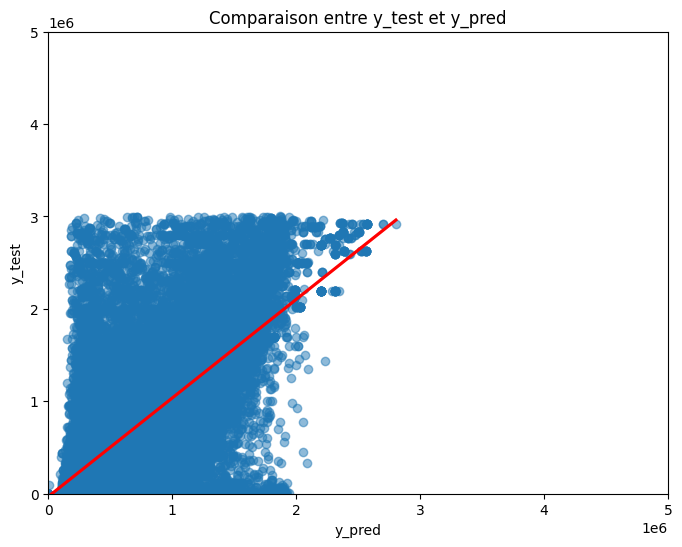

In [19]:
validation = pl.DataFrame()
validation = pl.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred
})

# Tracer avec seaborn
plt.figure(figsize=(8, 6))
sns.regplot(x=y_pred, y=y_test, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.xlabel("y_pred")
plt.ylabel("y_test")
plt.xlim(0,5e6)
plt.ylim(0,5e6)
plt.title("Comparaison entre y_test et y_pred")
plt.show()


In [20]:
class YToNumpyTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, y):
        if isinstance(y, (pl.DataFrame, pl.Series)):
            y = y.to_numpy()
        return np.log(y)
    def inverse_transform(self, y):
        # Si aucune transformation inverse n'est nécessaire, renvoyez simplement y
        return np.exp(y)

class ToNumpyTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Si X est un DataFrame ou une série Polars, le convertir en NumPy array
        if isinstance(X, pl.DataFrame):
            return X.to_numpy()
        elif isinstance(X, pl.Series):
            return X.to_numpy().reshape(-1, 1)
        return X

model = CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.1, loss_function='RMSE')
catboost_pipeline = Pipeline([
    ('preprocess', column_transformer),
    ('to_numpy',ToNumpyTransformer()),
    ('catboost_model',model)
])



# Pipeline pour X
catboost_pipeline = Pipeline([
    ('preprocess', column_transformer),
    ('to_numpy', ToNumpyTransformer()),
    ('catboost_model', model)
])

# Pipeline pour y avec TransformedTargetRegressor
final_pipeline = TransformedTargetRegressor(
    regressor=catboost_pipeline,
    transformer=YToNumpyTransformer()
)
display(final_pipeline)

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocess',
                                                      ColumnTransformer(transformers=[('onehot',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer(strategy='most_frequent')),
                                                                                                       ('onehot',
                                                                                                        OneHotEncoder(handle_unknown='ignore'))]),
                                                                                       ['nature_culture',
                                                                                        'type_local']),
                                                                                      ('numeric',
                                                                                       Pipeline(steps=[('replace_null_to_nan',
                                                                                                        FunctionTransformer(func=<function repl...
                                                                                                       ('imputer',
                                                                                                        SimpleImputer(fill_value=0,
                                                                                                                      strategy='constant')),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['surface_reelle_bati',
                                                                                        'nombre_pieces_principales',
                                                                                        'surface_terrain',
                                                                                        'longitude',
                                                                                        'latitude',
                                                                                        'sin_month',
                                                                                        'cos_month'])])),
                                                     ('to_numpy',
                                                      ToNumpyTransformer()),
                                                     ('catboost_model',
                                                      <catboost.core.CatBoostRegressor object at 0x7fdf49683370>)]),
                           transformer=YToNumpyTransformer())

0:	learn: 1.4768303	total: 90.4ms	remaining: 1m 30s
1:	learn: 1.4534496	total: 119ms	remaining: 59.2s
2:	learn: 1.4341066	total: 148ms	remaining: 49.1s
3:	learn: 1.4163120	total: 182ms	remaining: 45.2s
4:	learn: 1.4023973	total: 211ms	remaining: 42s
5:	learn: 1.3901607	total: 237ms	remaining: 39.3s
6:	learn: 1.3776885	total: 266ms	remaining: 37.7s
7:	learn: 1.3676843	total: 296ms	remaining: 36.7s
8:	learn: 1.3586621	total: 331ms	remaining: 36.5s
9:	learn: 1.3511609	total: 360ms	remaining: 35.7s
10:	learn: 1.3447618	total: 388ms	remaining: 34.9s
11:	learn: 1.3358439	total: 418ms	remaining: 34.4s
12:	learn: 1.3308104	total: 447ms	remaining: 33.9s
13:	learn: 1.3239986	total: 474ms	remaining: 33.4s
14:	learn: 1.3196571	total: 505ms	remaining: 33.2s
15:	learn: 1.3154419	total: 536ms	remaining: 33s
16:	learn: 1.3117310	total: 573ms	remaining: 33.1s
17:	learn: 1.3081206	total: 602ms	remaining: 32.9s
18:	learn: 1.3053903	total: 630ms	remaining: 32.5s
19:	learn: 1.3017783	total: 662ms	remaining

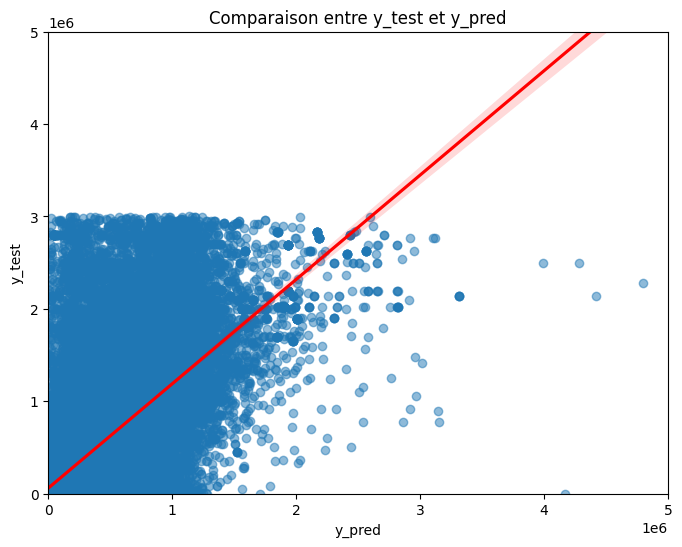

In [21]:
final_pipeline.fit(X_train,y_train)
y_pred = final_pipeline.predict(X_test)

r2 =  r2_score(y_test,y_pred)
print(f' R² = {r2}')
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
print(f'MAPE: {mape:.2f}%')
validation = pl.DataFrame()
validation = pl.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred
})

# Tracer avec seaborn
plt.figure(figsize=(8, 6))
sns.regplot(x=y_pred, y=y_test, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.xlabel("y_pred")
plt.ylabel("y_test")
plt.xlim(0,5e6)
plt.ylim(0,5e6)
plt.title("Comparaison entre y_test et y_pred")
plt.show()


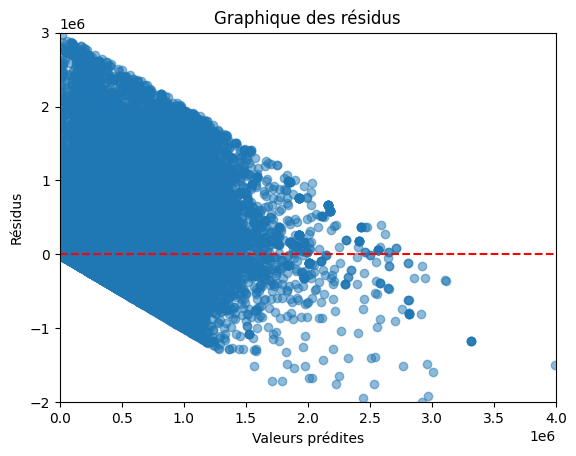

In [22]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlim(0,0.4e7)
plt.ylim(-0.2e7,0.3e7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.title('Graphique des résidus')
plt.show()


Beaucoup d'hétéroscédasticité

## Modele plus puissant: Feature engineering

In [23]:
path = 'data_dvf'
df = data_loader(path,departements=[75,92,93,94])
df.head()

id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
str,date,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,f64,str,f64,str,f64,str,f64,f64,str,str,f64,f64,str,str,str,str,f64,f64,f64
"""2023-1317095""",2023-01-03,"""1""","""Vente""",1.825e6,"""89""",null,"""RUE SAINT-DENIS""","""8525""","""75001""","""75101""","""Paris 1er Arrondissement""","""75""",null,null,"""75101000AP0050""",null,null,"""1""",95.21,"""26""",null,"""27""",null,"""28""",null,"""29""",null,7.0,"""4""","""Local industriel. commercial o…",165.0,0.0,null,null,null,null,null,2.349112,48.862083
"""2023-1317096""",2023-01-05,"""1""","""Vente""",567000.0,"""51""",null,"""RUE DE L ECHIQUIER""","""3084""","""75010""","""75110""","""Paris 10e Arrondissement""","""75""",null,null,"""75110000AV0075""",null,null,"""7""",null,"""8""",null,null,null,null,null,null,null,2.0,"""4""","""Local industriel. commercial o…",52.0,0.0,null,null,null,null,null,2.348283,48.871818
"""2023-1317097""",2023-01-04,"""1""","""Vente""",140000.0,"""178""",null,"""RUE DE COURCELLES""","""2387""","""75017""","""75117""","""Paris 17e Arrondissement""","""75""",null,null,"""75117000BG0053""",null,null,"""57""",18.75,"""58""",null,null,null,null,null,null,null,2.0,"""2""","""Appartement""",18.0,1.0,null,null,null,null,null,2.298612,48.884255
"""2023-1317098""",2023-01-05,"""1""","""Vente""",400000.0,"""12""",null,"""RUE TURGOT""","""9508""","""75009""","""75109""","""Paris 9e Arrondissement""","""75""",null,null,"""75109000BD0036""",null,null,"""831""",43.8,null,null,null,null,null,null,null,null,1.0,"""2""","""Appartement""",43.0,1.0,null,null,null,null,null,2.345859,48.880564
"""2023-1317099""",2023-01-04,"""1""","""Vente""",141343.12,"""63""","""B""","""RUE DAMREMONT""","""2534""","""75018""","""75118""","""Paris 18e Arrondissement""","""75""",null,null,"""75118000AK0014""",null,null,"""34""",11.4,null,null,null,null,null,null,null,null,1.0,"""3""","""Dépendance""",null,0.0,null,null,null,null,null,2.334615,48.891525


In [24]:
df = df.filter(
    pl.col("valeur_fonciere").is_not_null() &
    pl.col("longitude").is_not_null() &
    pl.col("latitude").is_not_null() &
    (pl.col("surface_reelle_bati").is_not_nan() | pl.col("surface_terrain").is_not_nan())
)

data = df[['date_mutation','type_local','surface_reelle_bati','nombre_lots','lot1_surface_carrez','lot2_surface_carrez','lot3_surface_carrez','lot4_surface_carrez','lot5_surface_carrez','nombre_pieces_principales','nature_culture','surface_terrain','longitude','latitude','valeur_fonciere']]


data = data.with_columns([
    pl.col("date_mutation").dt.month().map_batches(lambda x: np.sin(2 * np.pi * x / 12), return_dtype=pl.Float64).alias("sin_month"),
    pl.col("date_mutation").dt.month().map_batches(lambda x: np.cos(2 * np.pi * x / 12), return_dtype=pl.Float64).alias("cos_month"),
    pl.col("date_mutation").dt.year().alias('year'),
    pl.col('lot1_surface_carrez').fill_null(value=0),
    pl.col('lot2_surface_carrez').fill_null(value=0),
    pl.col('lot3_surface_carrez').fill_null(value=0),
    pl.col('lot4_surface_carrez').fill_null(value=0),
    pl.col('lot5_surface_carrez').fill_null(value=0),
    pl.col('surface_reelle_bati').fill_null(value=0),
    pl.col('surface_terrain').fill_null(value=0)
])


In [25]:
data = data.with_columns(
    (pl.col('lot1_surface_carrez')+pl.col('lot2_surface_carrez')+pl.col('lot3_surface_carrez')+pl.col('lot4_surface_carrez')+pl.col('lot5_surface_carrez')
).alias("total_surface_carrez"))

data = data.with_columns(
    pl.when(pl.col("total_surface_carrez") == 0)
            .then(pl.col("surface_reelle_bati"))
            .otherwise(pl.col("total_surface_carrez"))
            .alias("total_surface_carrez"),
    pl.when(pl.col("surface_reelle_bati") != 0)
            .then((pl.col("valeur_fonciere")/pl.col("surface_reelle_bati")).round(0))
            .otherwise((pl.col("valeur_fonciere")/pl.col("surface_terrain")).round(0))
            .alias("valeur_fonciere_m2")
)
data.head()

date_mutation,type_local,surface_reelle_bati,nombre_lots,lot1_surface_carrez,lot2_surface_carrez,lot3_surface_carrez,lot4_surface_carrez,lot5_surface_carrez,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,valeur_fonciere,sin_month,cos_month,year,total_surface_carrez,valeur_fonciere_m2
date,str,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,i32,f64,f64
2023-01-03,"""Local industriel. commercial o…",165.0,7.0,95.21,0.0,0.0,0.0,0.0,0.0,null,0.0,2.349112,48.862083,1.825e6,0.5,0.866025,2023,95.21,11061.0
2023-01-05,"""Local industriel. commercial o…",52.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,2.348283,48.871818,567000.0,0.5,0.866025,2023,52.0,10904.0
2023-01-04,"""Appartement""",18.0,2.0,18.75,0.0,0.0,0.0,0.0,1.0,null,0.0,2.298612,48.884255,140000.0,0.5,0.866025,2023,18.75,7778.0
2023-01-05,"""Appartement""",43.0,1.0,43.8,0.0,0.0,0.0,0.0,1.0,null,0.0,2.345859,48.880564,400000.0,0.5,0.866025,2023,43.8,9302.0
2023-01-03,"""Appartement""",28.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,null,0.0,2.318419,48.893075,295000.0,0.5,0.866025,2023,28.0,10536.0


In [26]:
from scipy.spatial import cKDTree
def idw_predict_kdtree(data, lon_col="longitude", lat_col="latitude", value_col="valeur_fonciere_m2", power=2, k=10):
    """
    Prédit les valeurs d'un DataFrame en utilisant l'Interpolation Inverse Distance Weighting (IDW) optimisée avec un KD-Tree.

    Paramètres :
        data : pl.DataFrame, DataFrame contenant les colonnes latitude, longitude et valeur foncière.
        lat_col : str, nom de la colonne latitude.
        lon_col : str, nom de la colonne longitude.
        value_col : str, nom de la colonne des valeurs à prédire.
        power : float, puissance de pondération (typiquement 2).
        k : int, nombre de voisins à considérer pour chaque point.

    Retourne :
        pl.Series, colonne des valeurs prédites pour chaque point.
    """
    # Extraire les coordonnées et les valeurs
    coordinates = data.select([lat_col, lon_col]).to_numpy()
    values = data[value_col].to_numpy()

    # Construire le KD-Tree
    tree = cKDTree(coordinates)

    predicted_values = []
    for i, point in enumerate(coordinates):
        # Trouver les k voisins les plus proches
        distances, indices = tree.query(point, k=k + 1)  # k+1 car le point lui-même est inclus

        # Exclure le point lui-même (distance 0)
        mask = distances > 0
        distances = distances[mask]
        indices = indices[mask]

        # Si aucun voisin valide n'est trouvé
        if len(distances) == 0:
            predicted_values.append(values[i])  # Retourner la valeur du point lui-même
            continue

        # Calculer les poids en fonction des distances
        weights = 1 / (distances ** power)

        # Calculer la valeur interpolée
        interpolated_value = np.round(np.sum(weights * values[indices]) / np.sum(weights),-1)
        predicted_values.append(interpolated_value)

    return pl.Series(predicted_values).alias(f"{value_col}_predite_par_le_quartier")


In [27]:
data = data.with_columns(
    idw_predict_kdtree(data, lon_col="longitude",lat_col="latitude", value_col="valeur_fonciere_m2", k=100),
)
data.head()

date_mutation,type_local,surface_reelle_bati,nombre_lots,lot1_surface_carrez,lot2_surface_carrez,lot3_surface_carrez,lot4_surface_carrez,lot5_surface_carrez,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,valeur_fonciere,sin_month,cos_month,year,total_surface_carrez,valeur_fonciere_m2,valeur_fonciere_m2_predite_par_le_quartier
date,str,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,i32,f64,f64,f64
2023-01-03,"""Local industriel. commercial o…",165.0,7.0,95.21,0.0,0.0,0.0,0.0,0.0,null,0.0,2.349112,48.862083,1.825e6,0.5,0.866025,2023,95.21,11061.0,37650.0
2023-01-05,"""Local industriel. commercial o…",52.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,2.348283,48.871818,567000.0,0.5,0.866025,2023,52.0,10904.0,16140.0
2023-01-04,"""Appartement""",18.0,2.0,18.75,0.0,0.0,0.0,0.0,1.0,null,0.0,2.298612,48.884255,140000.0,0.5,0.866025,2023,18.75,7778.0,12830.0
2023-01-05,"""Appartement""",43.0,1.0,43.8,0.0,0.0,0.0,0.0,1.0,null,0.0,2.345859,48.880564,400000.0,0.5,0.866025,2023,43.8,9302.0,15710.0
2023-01-03,"""Appartement""",28.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,null,0.0,2.318419,48.893075,295000.0,0.5,0.866025,2023,28.0,10536.0,9240.0


In [28]:
path_popd ='data_pop_density/fra_pd_2020_1km_ASCII_XYZ.csv'
df_popd = pl.read_csv(path_popd).rename({'X': 'lon','Y':'lat','Z':'densite'})
df_popd.sort('densite')

lon,lat,densite
f64,f64,f64
5.36125,49.287083,0.0
5.36125,49.27875,0.0
5.369583,49.27875,0.0
5.352917,49.270417,0.0
5.36125,49.270417,0.0
…,…,…
2.352917,48.887083,42190.984375
2.377917,48.870417,42973.605469
2.377917,48.85375,43308.148438


In [29]:
import numpy as np
import polars as pl
from scipy.spatial import cKDTree  # Importer cKDTree pour une recherche efficace des plus proches voisins

# Fonction pour trouver la densité la plus proche en utilisant cKDTree
def find_nearest_density(data, df_popd):
    """
    Trouve la densité de population du point le plus proche pour chaque point dans un DataFrame de données
    géographiques en utilisant un arbre k-d (cKDTree).

    Cette fonction cherche, pour chaque point dans `data`, le point le plus proche dans `df_popd`
    (en fonction de la distance géographique) et retourne la densité associée à ce point.

    Parameters:
    - data (polars.DataFrame): Le DataFrame contenant les coordonnées géographiques des points
      pour lesquels la densité doit être calculée. Il doit contenir les colonnes 'latitude' et 'longitude'.
    - df_popd (polars.DataFrame): Le DataFrame contenant les coordonnées géographiques des points
      de population et la densité associée. Il doit contenir les colonnes 'lat', 'lon' et 'densite'.

    Returns:
    - numpy.ndarray: Un tableau contenant les densités associées aux plus proches voisins pour
      chaque point de `data`.
    """
    latitudes_data = data['latitude'].to_numpy()
    longitudes_data = data['longitude'].to_numpy()

    latitudes_popd = df_popd['lat'].to_numpy()
    longitudes_popd = df_popd['lon'].to_numpy()
    densities_popd = df_popd['densite'].to_numpy()

    # Créer un cKDTree pour une recherche rapide des plus proches voisins
    tree = cKDTree(np.vstack((longitudes_popd, latitudes_popd)).T)

    # Chercher les voisins les plus proches pour chaque point de `data`
    distances, indices = tree.query(np.vstack((longitudes_data, latitudes_data)).T, k=4)

    # Récupérer les densités associées aux plus proches voisins
    nearest_densities = np.mean(densities_popd[indices], axis=1)

    return nearest_densities

# Appliquer la fonction pour ajouter la colonne 'nearest_density' au DataFrame
nearest_densities = find_nearest_density(data, df_popd)

# Ajouter la colonne 'nearest_density' à ton DataFrame Polars
data = data.with_columns(
    pl.Series('nearest_density', nearest_densities)
)

# Afficher le DataFrame résultant
data.head()


date_mutation,type_local,surface_reelle_bati,nombre_lots,lot1_surface_carrez,lot2_surface_carrez,lot3_surface_carrez,lot4_surface_carrez,lot5_surface_carrez,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,valeur_fonciere,sin_month,cos_month,year,total_surface_carrez,valeur_fonciere_m2,valeur_fonciere_m2_predite_par_le_quartier,nearest_density
date,str,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,i32,f64,f64,f64,f64
2023-01-03,"""Local industriel. commercial o…",165.0,7.0,95.21,0.0,0.0,0.0,0.0,0.0,null,0.0,2.349112,48.862083,1.825e6,0.5,0.866025,2023,95.21,11061.0,37650.0,23625.482666
2023-01-05,"""Local industriel. commercial o…",52.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,2.348283,48.871818,567000.0,0.5,0.866025,2023,52.0,10904.0,16140.0,31969.799316
2023-01-04,"""Appartement""",18.0,2.0,18.75,0.0,0.0,0.0,0.0,1.0,null,0.0,2.298612,48.884255,140000.0,0.5,0.866025,2023,18.75,7778.0,12830.0,28359.632812
2023-01-05,"""Appartement""",43.0,1.0,43.8,0.0,0.0,0.0,0.0,1.0,null,0.0,2.345859,48.880564,400000.0,0.5,0.866025,2023,43.8,9302.0,15710.0,35389.794922
2023-01-03,"""Appartement""",28.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,null,0.0,2.318419,48.893075,295000.0,0.5,0.866025,2023,28.0,10536.0,9240.0,31816.348145


In [30]:
# import psycopg2
# import polars as pl

# def get_poi_counts(latitude, longitude, radius, db_params):
#     """
#     Récupère les comptes des POI autour d'une localisation donnée.

#     Args:
#         latitude (float): Latitude de la localisation.
#         longitude (float): Longitude de la localisation.
#         db_config (dict): Dictionnaire contenant les informations de connexion à la base de données.
#                           Exemple: {
#                               'host': 'localhost',
#                               'port': 5432,
#                               'dbname': 'osm_db',
#                               'user': 'your_username',
#                               'password': 'your_password'
#                           }

#     Returns:
#         pl.DataFrame: DataFrame Polars avec les comptes des POI.
#     """
#     query = """
#     SELECT
#         COUNT(CASE WHEN public_transport IN ('stop_position', 'station', 'subway', 'railway') THEN 1 END) AS transport_pois,
#         COUNT(CASE WHEN amenity IN ('school', 'college', 'prep_school') THEN 1 END) AS education_pois,
#         COUNT(CASE WHEN amenity IN ('hospital', 'clinic', 'pharmacy', 'doctors') THEN 1 END) AS health_pois,
#         COUNT(CASE WHEN amenity IN ('restaurant', 'cafe', 'bar', 'pub', 'fast_food') THEN 1 END) AS food_pois,
#         COUNT(CASE WHEN amenity IN ('marketplace') OR shop IS NOT NULL THEN 1 END) AS shopping_pois,
#         COUNT(CASE WHEN leisure IN ('park') THEN 1 END) AS park_pois,
#         COUNT(CASE WHEN amenity IN ('cinema', 'theatre', 'bowling', 'nightclub') THEN 1 END) AS entertainment_pois,
#         COUNT(CASE WHEN amenity IN ('library', 'community_centre', 'arts_centre', 'museum') THEN 1 END) AS cultural_pois
#     FROM public.planet_osm_point
#     WHERE ST_DWithin(
#         ST_Transform(way, 3857),
#         ST_Transform(ST_SetSRID(ST_MakePoint(%s, %s), 4326), 3857),
#         %s
#     )
#     AND (
#         (public_transport IN ('stop_position', 'station', 'subway', 'railway') AND name IS NOT NULL)
#         OR
#         (amenity IN ('school', 'college', 'prep_school') AND name IS NOT NULL)
#         OR
#         (amenity IN ('hospital', 'clinic', 'pharmacy', 'doctors') AND name IS NOT NULL)
#         OR
#         (amenity IN ('restaurant', 'cafe', 'bar', 'pub', 'fast_food') AND name IS NOT NULL)
#         OR
#         ((amenity IN ('marketplace') OR shop IS NOT NULL) AND name IS NOT NULL)
#         OR
#         (leisure IN ('park') AND name IS NOT NULL)
#         OR
#         (amenity IN ('cinema', 'theatre', 'bowling', 'nightclub') AND name IS NOT NULL)
#         OR
#         (amenity IN ('library', 'community_centre', 'arts_centre', 'museum') AND name IS NOT NULL)
#     );
#     """
#     # Connexion à la base de données
#     conn = None
#     try:
#         conn = psycopg2.connect(
#             host=db_params['host'],
#             port=db_params['port'],
#             dbname=db_params['dbname'],
#             user=db_params['user'],
#             password=db_params['password']
#         )
#         with conn.cursor() as cur:
#             # Exécuter la requête
#             cur.execute(query, (longitude, latitude, radius))
#             # Récupérer les résultats
#             columns = [desc[0] for desc in cur.description]
#             data = cur.fetchall()

#         # Créer un DataFrame Polars
#         df = pl.DataFrame(data, schema=columns)
#         return df
#     except Exception as e:
#         print(f"Erreur lors de l'exécution de la requête : {e}")
#     finally:
#         if conn:
#             conn.close()


In [31]:
db_params = {
    'dbname': 'osm_db',
    'user': 'phdel',
    'port' : 5432,
    'password': 'your_password',
    'host': 'localhost'
}
lat, lon, dens = 48.8566, 2.3522, 5000
radius = 500
pois = get_poi_counts(lat, lon, radius, db_params)
print(pois)


shape: (1, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ transport_ ┆ education_ ┆ health_poi ┆ food_pois ┆ shopping_ ┆ park_pois ┆ entertain ┆ cultural_ │
│ pois       ┆ pois       ┆ s          ┆ ---       ┆ pois      ┆ ---       ┆ ment_pois ┆ pois      │
│ ---        ┆ ---        ┆ ---        ┆ i64       ┆ ---       ┆ i64       ┆ ---       ┆ ---       │
│ i64        ┆ i64        ┆ i64        ┆           ┆ i64       ┆           ┆ i64       ┆ i64       │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 26         ┆ 3          ┆ 7          ┆ 116       ┆ 216       ┆ 0         ┆ 2         ┆ 2         │
└────────────┴────────────┴────────────┴───────────┴───────────┴───────────┴───────────┴───────────┘


/home/phdel/.pyenv/versions/3.10.6/lib/python3.10/functools.py:889: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  return dispatch(args[0].__class__)(*args, **kw)


In [59]:
import psycopg2

def get_poi_counts(latitude, longitude, radius, db_params):
    """
    Récupère les comptes des POI autour d'une localisation donnée.

    Args:
        latitude (float): Latitude de la localisation.
        longitude (float): Longitude de la localisation.
        db_params (dict): Dictionnaire contenant les informations de connexion à la base de données.

    Returns:
        dict: Dictionnaire contenant les comptes des POI.
    """
    query = """
    SELECT
        COUNT(CASE WHEN public_transport IN ('stop_position', 'station', 'subway', 'railway') THEN 1 END) AS transport_pois,
        COUNT(CASE WHEN amenity IN ('school', 'college', 'prep_school') THEN 1 END) AS education_pois,
        COUNT(CASE WHEN amenity IN ('hospital', 'clinic', 'pharmacy', 'doctors') THEN 1 END) AS health_pois,
        COUNT(CASE WHEN amenity IN ('restaurant', 'cafe', 'bar', 'pub', 'fast_food') THEN 1 END) AS food_pois,
        COUNT(CASE WHEN amenity IN ('marketplace') OR shop IS NOT NULL THEN 1 END) AS shopping_pois,
        COUNT(CASE WHEN leisure IN ('park') THEN 1 END) AS park_pois,
        COUNT(CASE WHEN amenity IN ('cinema', 'theatre', 'bowling', 'nightclub') THEN 1 END) AS entertainment_pois,
        COUNT(CASE WHEN amenity IN ('library', 'community_centre', 'arts_centre', 'museum') THEN 1 END) AS cultural_pois
    FROM public.planet_osm_point
    WHERE ST_DWithin(
        ST_Transform(way, 3857),
        ST_Transform(ST_SetSRID(ST_MakePoint(%s, %s), 4326), 3857),
        %s
    )
    AND (
        (public_transport IN ('stop_position', 'station', 'subway', 'railway') AND name IS NOT NULL)
        OR
        (amenity IN ('school', 'college', 'prep_school') AND name IS NOT NULL)
        OR
        (amenity IN ('hospital', 'clinic', 'pharmacy', 'doctors') AND name IS NOT NULL)
        OR
        (amenity IN ('restaurant', 'cafe', 'bar', 'pub', 'fast_food') AND name IS NOT NULL)
        OR
        ((amenity IN ('marketplace') OR shop IS NOT NULL) AND name IS NOT NULL)
        OR
        (leisure IN ('park') AND name IS NOT NULL)
        OR
        (amenity IN ('cinema', 'theatre', 'bowling', 'nightclub') AND name IS NOT NULL)
        OR
        (amenity IN ('library', 'community_centre', 'arts_centre', 'museum') AND name IS NOT NULL)
    );
    """
    # Connexion à la base de données
    conn = None
    try:
        conn = psycopg2.connect(
            host=db_params['host'],
            port=db_params['port'],
            dbname=db_params['dbname'],
            user=db_params['user'],
            password=db_params['password']
        )
        with conn.cursor() as cur:
            # Exécuter la requête
            cur.execute(query, (longitude, latitude, radius))
            # Récupérer les résultats
            columns = [desc[0] for desc in cur.description]
            data = cur.fetchone()  # Seulement une ligne avec les résultats
            if data:
                result = dict(zip(columns, data))
                return result
    except Exception as e:
        print(f"Erreur lors de l'exécution de la requête : {e}")
    finally:
        if conn:
            conn.close()
    return {}


In [71]:
def add_poi_counts_to_df(df, db_params, radius=500):
    """
    Ajoute les colonnes POI à un DataFrame existant avec des latitudes et longitudes.

    Args:
        df (pd.DataFrame): DataFrame contenant les colonnes 'lat' et 'lon'.
        db_params (dict): Paramètres de connexion à la base de données.
        radius (int): Rayon de recherche pour les POIs autour des coordonnées.

    Returns:
        pd.DataFrame: DataFrame avec les nouvelles colonnes POI.
    """
    df = df.to_pandas()
    df['poi_counts'] = df.apply(lambda row: get_poi_counts(row['lat'], row['lon'], radius, db_params), axis=1)

    # Convertir les résultats des POIs (qui sont des dictionnaires) en DataFrame
    poi_df = pd.json_normalize(df['poi_counts'])

    # Ajouter les nouvelles colonnes au DataFrame d'origine
    df = pd.concat([df.drop(columns=['poi_counts']), poi_df], axis=1)

    return pl.from_pandas(df)

# Appliquer la fonction sur votre DataFrame
df_pop_better = add_poi_counts_to_df(df_popd, db_params)

# Afficher le DataFrame final
df_pop_better.write_csv("data_pop_density/dataframe_densite&amenities.csv")


KeyboardInterrupt: 

In [35]:

# # Fonction pour ajouter les colonnes avec les résultats des fonctions
# def enrich_with_overpass_data(df, radius = 500):
#     print("Enrichissement des données avec les résultats des fonctions Overpass API...")

#     # Initialisation des listes pour les nouvelles colonnes
#     amenities = []
#     transports = []
#     shops = []
#     schools = []
#     parks = []
#     restaurants = []
#     healthcare = []
#     entertainment = []
#     cultural_places = []

#     # Conversion en dictionnaire pour parcourir les lignes
#     df_dict = df.to_dict(as_series=False)

#     for lat, lon in zip(df_dict['lat'], df_dict['lon']):
#         try:
#             print(f"Traitement pour les coordonnées ({lat}, {lon})...")
#             amenities.append(get_all_amenities(lat, lon, radius))
#             transports.append(get_nearby_transports(lat, lon, radius))
#             shops.append(get_nearby_shops(lat, lon, radius))
#             schools.append(get_nearby_schools(lat, lon, radius))
#             parks.append(get_nearby_parks(lat, lon, radius))
#             restaurants.append(get_nearby_restaurants(lat, lon, radius))
#             healthcare.append(get_nearby_healthcare(lat, lon, radius))
#             entertainment.append(get_nearby_entertainment(lat, lon, radius))
#             cultural_places.append(get_nearby_cultural_places(lat, lon, radius))
#         except Exception as e:
#             print(f"Erreur pour ({lat}, {lon}): {e}")
#             amenities.append(None)
#             transports.append(None)
#             shops.append(None)
#             schools.append(None)
#             parks.append(None)
#             restaurants.append(None)
#             healthcare.append(None)
#             entertainment.append(None)
#             cultural_places.append(None)

#     # Ajout des colonnes au DataFrame Polars
#     df = df.with_columns([
#         pl.Series("amenities", amenities),
#         pl.Series("transports", transports),
#         pl.Series("shops", shops),
#         pl.Series("schools", schools),
#         pl.Series("parks", parks),
#         pl.Series("restaurants", restaurants),
#         pl.Series("healthcare", healthcare),
#         pl.Series("entertainment", entertainment),
#         pl.Series("cultural_places", cultural_places),
#     ])

#     print("Enrichissement terminé.")
#     return df

# # Appel de la fonction pour enrichir df_popd
# df_popd = enrich_with_overpass_data(df_popd)

# # Afficher les premières lignes pour vérifier
# print(df_popd.head())


In [36]:
# def fetch_all_pois(lat, lon, radius=500):
#     overpass_url = "http://overpass-api.de/api/interpreter"
#     overpass_query = f"""
#     [out:json];
#     (
#       node["amenity"](around:{radius}, {lat}, {lon});
#       way["amenity"](around:{radius}, {lat}, {lon});
#       relation["amenity"](around:{radius}, {lat}, {lon});
#     );
#     out body;
#     """
#     retries = 3
#     for i in range(retries):
#         try:
#             response = requests.get(overpass_url, params={'data': overpass_query})
#             response.raise_for_status()  # Will raise an HTTPError for bad status codes
#             return response.json()
#         except requests.exceptions.RequestException as e:
#             print(f"Request failed: {e}")
#             if i < retries - 1:
#                 print(f"Retrying... ({i+1}/{retries})")
#                 time.sleep(5)  # Wait for 5 seconds before retrying
#             else:
#                 raise Exception(f"Failed to fetch data after {retries} attempts")


# def dict_amenities(lat,lon,dens,data):
#     results = {"lat": lat, "lon": lon, "densite": dens, "amenities": 0, "transports": 0, "shops": 0, "schools": 0,
#                "parks": 0, "restaurants": 0, "healthcare": 0,
#                "entertainment": 0, "cultural_places": 0}

#     for element in data.get("elements", []):
#         tags = element.get("tags", {})


#         if tags.get("amenity") in {"school", "college", "prep_school"}:
#             results["schools"] += 1
#         elif tags.get("amenity") in {"hospital", "clinic", "pharmacy", "doctors"}:
#             results["healthcare"] += 1
#         elif tags.get("amenity") in {"restaurant", "cafe", "bar", "pub", "fast_food"}:
#             results["restaurants"] += 1
#         elif tags.get("amenity") in {"marketplace", "shop"}:
#             results["shops"] += 1
#         elif tags.get("leisure") == "park":
#             results["parks"] += 1
#         elif tags.get("amenity") in {"cinema", "theatre", "bowling", "nightclub"}:
#             results["entertainment"] += 1
#         elif tags.get("amenity") in {"library", "community_centre", "arts_centre"} or tags.get("tourism") == "museum":
#             results["cultural_places"] += 1
#         else:
#             results["amenities"] += 1

#     return results
# def save_partial_results(filename, df):
#     df.write_csv(filename)

# def enrich_with_combined_overpass(df, radius=500, backup_file="backup.csv", min_density = 200, save_interval=1000,backup_status = False):
#     print("Enrichissement des données avec les résultats des fonctions Overpass API...")

#     # Initialisation des listes pour les colonnes à ajouter

#     result = pl.DataFrame()
#     # Parcourir les lignes du DataFrame
#     start_idx = 0
#     if backup_status and os.path.exists(backup_file):
#         print(f"Reprise à partir du fichier de sauvegarde : {backup_file}")
#         result = pl.read_csv(backup_file)
#         start_idx = result.shape[0]  # Nombre de lignes déjà traitées
#         print(f"Reprise des calculs à partir de la ligne {start_idx}...")
#         # Filtrage des lignes déjà traitées
#         rows_to_process = df.rows()[start_idx:]

#     for idx, row in enumerate(rows_to_process):
#         lon, lat , dens = row[0], row[1], row[2]
#         if idx < start_idx:
#             continue

#         if dens >= min_density:
#             print(f"Traitement pour ({lat}, {lon})...")
#             response = fetch_all_pois(lat, lon, radius)
#             dict_amenity = dict_amenities(lat, lon, dens, response)
#         else:
#             dict_amenity = dict_amenities(lat,lon,dens, {})
#         if result.is_empty():
#             result = pl.DataFrame(dict_amenity)
#         else:
#             partial_df = pl.DataFrame(dict_amenity)
#             result = pl.concat([result,partial_df])
#         # Sauvegarder les résultats partiels à intervalles réguliers
#         if (idx + 1) % save_interval == 0:
#             print(f"Sauvegarde intermédiaire après {idx + 1} lignes...")
#             save_partial_results(backup_file, result)

#     # Ajouter les nouvelles colonnes au DataFrame
#     return result


In [37]:
# df_popd.filter(df_popd['densite']>=2000).shape

In [38]:
# df_popd = enrich_with_combined_overpass(df_popd, radius=500, backup_file="data_pop_density/pois_script_result copy.csv",min_density=2000, save_interval=1000,backup_status=True)
# df_popd.write_csv("data_pop_density/dataframe_densite_amenities.csv")

In [39]:
# df_popd.write_csv('data_pop_density/dataframe_densite_amenities.csv')